In [1]:
import numpy
import pandas

import conntility

from scipy.spatial.distance import cdist
import tqdm

from matplotlib import pyplot as plt

## Part 1:
Measure the strengths of statistical interactions in connectivity based on individual morphologies that are not capture by a fourth-order simplifed model

In [2]:
fn_rat = "/gpfs/bbp.cscs.ch/project/proj159/home/barros/conn_matrix/Rat_623um_squared_struc_conmat_filtered_compressed.h5"
fn_human = "/gpfs/bbp.cscs.ch/project/proj159/home/barros/conn_matrix/Human_960um_squared_struc_conmat_filtered_compressed.h5"

# https://doi.org/10.5281/zenodo.13849415
fn_microns = "/gpfs/bbp.cscs.ch/project/proj159/home/reimann/microns/microns_mm3_connectome_v1181.h5"

loaded = "rat"  # Set to human to analyze that instead

if loaded == "rat":
    M_h = conntility.ConnectivityMatrix.from_h5(fn_rat)
    col_y = "depth"
    col_xz = ["ss_flat_x", "ss_flat_y"]
    bin_sz = 50.0
elif loaded == "human":
    M_h = conntility.ConnectivityMatrix.from_h5(fn_human)
    col_y = "y"
    col_xz = ["x", "z"]
    bin_sz = 50.0 * 1.76
elif loaded == "microns":
    M_h = conntility.ConnectivityMatrix.from_h5(fn_microns, "condensed")
    M_h = M_h.index("cell_type").isin(["L2a", "L2b", "L2c", "L3a", "L3b"])
    for col in ["x", "y", "z"]:
        M_h.add_vertex_property(col, M_h.vertices[col + "_nm"].values / 1000)
    M_h.add_vertex_property("mtype", M_h.vertices["cell_type"].values)
    col_y = "y"
    col_xz = ["x", "z"]
    bin_sz = 50.0
    
def make_spatial_bins(M_h, cols, bin_sz):
    _data = M_h.vertices[cols]
    delta = _data.max() - _data.min()

    sz = numpy.sqrt((delta.values ** 2).sum())
    if len(delta) == 1: # case 1d: negative and positive bins
        bins = numpy.arange(0, (bin_sz * numpy.ceil(sz / bin_sz)) + bin_sz, bin_sz)
        bins = numpy.hstack([-bins[:0:-1], bins])
    else: # case 2d: Only positive bins, but exclude 0 dist
        bins = numpy.arange(0, (bin_sz * numpy.ceil(sz / bin_sz)) + bin_sz, bin_sz)
        bins = numpy.hstack([[0, 1E-12], bins[1:]])
    return bins

dbins_xz = make_spatial_bins(M_h, col_xz, bin_sz)
binid_xz = numpy.arange(0, len(dbins_xz) + 1)

dbins_y = make_spatial_bins(M_h, [col_y], bin_sz)
binid_y = numpy.arange(0, len(dbins_y) + 1)

bin_centers_y = 0.5 * (dbins_y[:-1] + dbins_y[1:])
bin_centers_xz = 0.5 * (dbins_xz[1:-1] + dbins_xz[2:])

M_h.vertices["mtype"].value_counts()

mtype
L3_TPC:A     8702
L2_TPC:B     7062
L3_TPC:C     2499
L2_TPC:A     1067
L2_IPC        707
L5_DBC          0
L5_LBC          0
L5_MC           0
L5_NBC          0
L5_NGC          0
L5_SBC          0
L5_TPC:A        0
L5_TPC:B        0
L5_TPC:C        0
L5_UPC          0
L6_BP           0
L1_DAC          0
L5_BTC          0
L6_BPC          0
L6_BTC          0
L6_CHC          0
L6_DBC          0
L6_HPC          0
L6_IPC          0
L6_LBC          0
L6_MC           0
L6_NBC          0
L6_NGC          0
L6_SBC          0
L6_TPC:A        0
L6_TPC:C        0
L5_CHC          0
L4_TPC          0
L5_BP           0
L23_NGC         0
L1_LAC          0
L1_NGC-DA       0
L1_NGC-SA       0
L1_SAC          0
L23_BP          0
L23_BTC         0
L23_CHC         0
L23_DBC         0
L23_LBC         0
L23_MC          0
L23_NBC         0
L23_SBC         0
L4_UPC          0
L4_BP           0
L4_BTC          0
L4_CHC          0
L4_DBC          0
L4_LBC          0
L4_MC           0
L4_NBC          0
L4_N

In [3]:
from scipy.spatial import KDTree

_coords = col_xz + [col_y]
tree = KDTree(M_h.vertices[_coords].values)

_, nn_id = tree.query(M_h.vertices[_coords], k=2)
nn_id = nn_id[:, 1]  # nn_id[:, 0] is the original node, which has distance 0. nn_id[:, 1] is neighbor

# Lookup from pre / post ids to edge ids
edge_id_lookup = M_h._edge_indices.reset_index(drop=True).reset_index().set_index(["row", "col"])["index"]

For this analysis we build a table as follows:

For each possible xz/y bin and value of n and m:
    We count the number of instances where a neuron N_a at offset xz, y from another neuron N_b has n touches/synapses with N_b, and the nearest neighbor of N_a has m touches/synapses with N_b.

In [4]:
def for_pre_chunk(chunk_pre):
    # Which offset bin the pairs fall into
    Dxz = cdist(M_h.vertices.iloc[chunk_pre][col_xz], M_h.vertices[col_xz]) # PRE X POST
    Dxz = numpy.digitize(Dxz, dbins_xz) - 2  # -2 means distance = 0 will be bin id -1. That is the one to exclude.

    Dy = M_h.vertices.iloc[chunk_pre][[col_y]].values - M_h.vertices[[col_y]].values.transpose() # PRE X POST
    Dy = numpy.digitize(Dy, dbins_y) - 1  # NOTE: Negative values -> upwards connection
    
    # Numer of touches between them
    j, i = numpy.meshgrid(numpy.arange(len(M_h)), chunk_pre) # Chunk is i.: Presyn.
    assert j.shape == Dy.shape
    con_index = pandas.MultiIndex.from_frame(pandas.DataFrame({"row": i.flatten(), "col": j.flatten()}))
    edge_ids = edge_id_lookup.reindex(con_index, fill_value=-1).values
    
    touch_count = numpy.zeros(len(edge_ids))
    v = edge_ids > 0
    touch_count[v] = M_h.edges["count"].values[edge_ids[v]]
    
    # Number of touches with nearest neighbor of the presynaptic neuron
    _pre = nn_id[i.flatten()]; _post = j.flatten()
    con_index = pandas.MultiIndex.from_frame(pandas.DataFrame({"row": _pre, "col": _post}))
    edge_ids = edge_id_lookup.reindex(con_index, fill_value=-1).values
    
    touch_count_nnpre = numpy.zeros(len(edge_ids))
    v = edge_ids > 0
    touch_count_nnpre[v] = M_h.edges["count"].values[edge_ids[v]]
    collision_pre = _pre != _post
    
    # Number of touches with nearest neighbor of the postsynaptic neuron
    _pre = i.flatten(); _post = nn_id[j.flatten()]
    con_index = pandas.MultiIndex.from_frame(pandas.DataFrame({"row": _pre, "col": _post}))
    edge_ids = edge_id_lookup.reindex(con_index, fill_value=-1).values
    
    touch_count_nnpost = numpy.zeros(len(edge_ids))
    v = edge_ids > 0
    touch_count_nnpost[v] = M_h.edges["count"].values[edge_ids[v]]
    collision_post = _pre != _post
    
    # Count instances of each
    ret_pre = pandas.DataFrame({
        "xz": Dxz.flatten()[collision_pre],
        "y": Dy.flatten()[collision_pre],
        "touches_pair": touch_count[collision_pre],
        "touches_nn_pre": touch_count_nnpre[collision_pre],
    }).value_counts()
    
    ret_post = pandas.DataFrame({
        "xz": Dxz.flatten()[collision_post],
        "y": Dy.flatten()[collision_post],
        "touches_pair": touch_count[collision_post],
        "touches_nn_post": touch_count_nnpost[collision_post],
    }).value_counts()
    return ret_pre, ret_post
    


In [5]:
#In each offset-bin: How many pairs exist?
full_master_pre = []
full_master_post = []
chunk_sz = 1000
chunking = numpy.arange(0, len(M_h) + chunk_sz, chunk_sz)

chunk_pre = numpy.arange(chunking[0], numpy.minimum(chunking[1], len(M_h)))
full_master_pre, full_master_post = for_pre_chunk(chunk_pre)

for a, b in tqdm.tqdm(list(zip(chunking[1:-1], chunking[2:]))):
    chunk_pre = numpy.arange(a, numpy.minimum(b, len(M_h)))
    new_master_pre, new_master_post = for_pre_chunk(chunk_pre)
    full_master_pre = full_master_pre.add(new_master_pre, fill_value=0)
    full_master_post = full_master_post.add(new_master_post, fill_value=0)


100%|██████████| 20/20 [06:07<00:00, 18.40s/it]


In [6]:
full_master_pre = full_master_pre.drop(-1, axis=0).reset_index()
full_master_post = full_master_post.drop(-1, axis=0).reset_index()


assert (full_master_pre[["xz", "y"]] >= 0).all().all()
assert (full_master_post[["xz", "y"]] >= 0).all().all()

assert (full_master_pre["xz"] < len(binid_xz)).all()
assert (full_master_pre["y"] < len(binid_y)).all()
assert (full_master_post["xz"] < len(binid_xz)).all()
assert (full_master_post["y"] < len(binid_y)).all()

In [7]:
full_master_pre["xz"] = bin_centers_xz[full_master_pre["xz"]]
full_master_pre["y"] = bin_centers_y[full_master_pre["y"]]

full_master_post["xz"] = bin_centers_xz[full_master_post["xz"]]
full_master_post["y"] = bin_centers_y[full_master_post["y"]]

In [8]:
out_fn = "/gpfs/bbp.cscs.ch/project/proj159/home/reimann/connectivity_higher_order_effect_24-11-11.h5"

full_master_pre.to_hdf(out_fn, key="{0}/pre".format(loaded))
full_master_post.to_hdf(out_fn, key="{0}/post".format(loaded))

## Part 2:
The above characterizes statistical interactions within one spatial bin. Here, we consider interactions _between_ bins. 

For this analysis we build a table as follows:

For each possible xz/y bin, value of n neuron N_b:
    We count the number of instances where a neuron N_a at offset xz, y from N_b has n touches/synapses with N_b. The difference  with respect to the previous analysis is that we count separately for each neuron N_b

In [9]:
edge_id_lookup = M_h._edge_indices.reset_index(drop=True).reset_index().set_index(["row", "col"])["index"]

def for_chunk(chunk, interaction_for="pre"):
    # Which offset bin the pairs fall into
    if interaction_for == "pre": # Pre means: from chunk to all neurons
        Dxz = cdist(M_h.vertices.iloc[chunk][col_xz], M_h.vertices[col_xz]) # PRE X POST
        Dxz = numpy.digitize(Dxz, dbins_xz) - 2  # -2 means distance = 0 will be bin id -1

        Dy = M_h.vertices.iloc[chunk][[col_y]].values - M_h.vertices[[col_y]].values.transpose() # PRE X POST
        Dy = numpy.digitize(Dy, dbins_y) - 1  # NOTE: Negative values -> upwards connection
        
        j, i = numpy.meshgrid(numpy.arange(len(M_h)), chunk) # chunk is i: presyn. => consider outgoing
        node_id = i.flatten()
    elif interaction_for == "post":
        Dxz = cdist(M_h.vertices[col_xz], M_h.vertices.iloc[chunk][col_xz]) # PRE X POST
        Dxz = numpy.digitize(Dxz, dbins_xz) - 2  # -2 means distance = 0 will be bin id -1

        Dy = M_h.vertices[[col_y]].values - M_h.vertices.iloc[chunk][[col_y]].values.transpose() # PRE X POST
        Dy = numpy.digitize(Dy, dbins_y) - 1  # NOTE: Negative values -> upwards connection
        
        j, i = numpy.meshgrid(chunk, numpy.arange(len(M_h))) # chunk is j: postsyn. => consider incoming
        node_id = j.flatten()
    
    # Numer of touches between them
    assert j.shape == Dy.shape
    con_index = pandas.MultiIndex.from_frame(pandas.DataFrame({"row": i.flatten(), "col": j.flatten()}))
    edge_ids = edge_id_lookup.reindex(con_index, fill_value=-1).values
    
    touch_count = numpy.zeros(len(edge_ids))
    v = edge_ids > 0
    touch_count[v] = M_h.edges["count"].values[edge_ids[v]]
    touch_count.reshape(Dy.shape)
        
    # Count instances of each
    ret = pandas.DataFrame({
        "xz": Dxz.flatten(),
        "y": Dy.flatten(),
        "touches_pair": touch_count,
        "node_id": node_id,
    }).value_counts()
    
    return ret
    


In [10]:
df_for_pre = []
df_for_post = []

chunk_sz = 2000
chunking = numpy.arange(0, len(M_h) + chunk_sz, chunk_sz)

for a, b in tqdm.tqdm(list(zip(chunking[:-1], chunking[1:]))):
    chunk = numpy.arange(a, numpy.minimum(b, len(M_h)))
    df_for_pre.append(for_chunk(chunk, interaction_for="pre"))
    df_for_post.append(for_chunk(chunk, interaction_for="post"))
    

df_for_pre = pandas.concat(df_for_pre, axis=0).drop(-1, axis=0, level="xz")
df_for_post = pandas.concat(df_for_post, axis=0).drop(-1, axis=0, level="xz")

100%|██████████| 11/11 [05:45<00:00, 31.44s/it]


Next, we convert the information in the table as follows: For each offset bin and neuron calculate the number of connected neurons in that bin and the total number of neurons (connected or not).

In [11]:
# We introduce a threshold for minimum number of touches to make the results sparser.
# For Microns connectivity or functional connectivity set to 1.
thresh = 1  # HOW MANY TOUCHES NEED TO BE REACHED FOR A CONNECTION

# For each pre- or post-neuron: How many partners does it have in each offset bin (N) and what fraction is connected (P)?
def count_n_and_p(df_in):
    M = df_in.pivot(index="touches_pair", columns="node_id", values="count") # "node_id"
    V = pandas.concat([M.sum(axis=0), M.loc[thresh:].sum(axis=0) / M.sum(axis=0)], axis=1, keys=["N", "P"])
    return V

df_n_p_pre = df_for_pre.reset_index().groupby(["xz", "y"]).apply(count_n_and_p)
df_n_p_post = df_for_post.reset_index().groupby(["xz", "y"]).apply(count_n_and_p)

An example for wat we consider. 

For a pair of spatial bins, we consider the connection probabilities of all neurons with partners at that offset.
Then we can ask, what is the correlation?

(-0.001, 0.025)

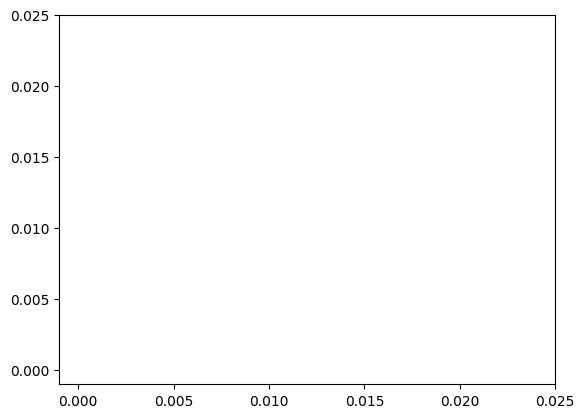

In [12]:
a = df_n_p_post.loc[(3, 10)]
b = df_n_p_post.loc[(4, 12)]

ab = pandas.concat([a["P"], b["P"]], axis=1, keys=["a", "b"], names=["bin"])

plt.scatter(ab["a"], ab["b"], alpha=0.4, s=5)
plt.gca().set_xlim([-1E-3, 0.025])
plt.gca().set_ylim([-1E-3, 0.025])

In [13]:
# Overall mean connection probability in each offset bin
mn_P_pre = df_n_p_pre.groupby(["xz", "y"]).apply(lambda _x: (_x["N"] * _x["P"]).sum() / _x["N"].sum())
mn_P_post = df_n_p_post.groupby(["xz", "y"]).apply(lambda _x: (_x["N"] * _x["P"]).sum() / _x["N"].sum())

# What is the correlation between observed values of "P" over pre- or post-neurons in a given offset bin?
def observations_to_cc_of_offset_bins(df_in, mode="valid"):
    df_cc = df_in.reset_index()
    # columns: offset bin. index: neuron. values: observed "P", or NaN if the neuron has no other neuron at that offset
    df_cc = df_cc.pivot(columns=["xz", "y"], index="node_id", values="P")
    # How to deal with NaN values? The default behavior of pandas is to ignore them, i.e. calculate correlation only
    # for observations where neither of a pair is NaN. 
    # A more conservative approach is to assume that the neuron would have the overall mean connection probability.
    # Finally we can add a small, random noise to all observations. That way, bins with all zeros will show up
    # to have zero correlation with all others. Else they will have NaN correlation
    if mode == "valid":
        return df_cc.corr()
    else:
        return (df_cc.fillna(mn_P) + 1E-9 * numpy.random.rand(*df_cc.shape)).corr()
    
CC_pre = observations_to_cc_of_offset_bins(df_n_p_pre)
CC_post = observations_to_cc_of_offset_bins(df_n_p_post)

In [14]:
def translate_index(idx):
    idx = idx.to_frame().reset_index(drop=True)
    idx["xz"] = bin_centers_xz[idx["xz"]]
    idx["y"] = bin_centers_y[idx["y"]]
    return pandas.MultiIndex.from_frame(idx)

CC_post.index = translate_index(CC_post.index)
CC_post.columns = translate_index(CC_post.columns)
CC_pre.index = translate_index(CC_pre.index)
CC_pre.columns = translate_index(CC_pre.columns)

In [15]:
out_fn = "/gpfs/bbp.cscs.ch/project/proj159/home/reimann/connectivity_higher_order_interactions_24-11-11.h5"

CC_pre.to_hdf(out_fn, key="{0}/{1}/pre".format(loaded, thresh))
CC_post.to_hdf(out_fn, key="{0}/{1}/post".format(loaded, thresh))

/gpfs/bbp.cscs.ch/home/reimann/venvs/bpsnap/lib/python3.10/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


In [16]:
mn_edge_count_pre = df_n_p_pre.groupby(["xz", "y"]).apply(lambda _x: _x["N"].mean())
mn_edge_count_pre.index = translate_index(mn_edge_count_pre.index)
mn_edge_count_post = df_n_p_post.groupby(["xz", "y"]).apply(lambda _x: _x["N"].mean())
mn_edge_count_post.index = translate_index(mn_edge_count_post.index)

In [17]:
out_fn = "/gpfs/bbp.cscs.ch/project/proj159/home/reimann/connectivity_higher_order_interactions_24-11-11.h5"

mn_edge_count_pre.to_hdf(out_fn, key="{0}/{1}/pre_N".format(loaded, thresh))
mn_edge_count_post.to_hdf(out_fn, key="{0}/{1}/post_N".format(loaded, thresh))